<a href="https://colab.research.google.com/github/DiegoMBrito/Sprint_2/blob/main/Deep_Learning/Modelos_DP/MVP_Sprint2_DP_Comentada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Definição do projeto

 Este projeto tem como foco a Classificação de amostras geológicas por meio de imagens utilizando o modelos de aprendizado de máquina. O objetivo principal é avaliar a eficácia e precisão das redes neurais utilizdas (CNN, Resnet50 e InceptionV3) na identificação de diferentes tipos de estruturas contidas em rochas. Esse estudo busca auxiliar profissionais no reconhecimento de estruturas geológicas assim como também fornecer conclusões relevantes sobre a aplicação de inteligência artificial em geologia e ciências da terra.

## 1. Importando e instalando algumas bibliotecas necessárias para executação deste notebook.

In [ ]:
# ! pip install tensorflow

# ! pip install keras

# ! pip install pandas

# ! pip install scikit-learn

# ! pip install wget

In [ ]:
# Importações de libs necessárias

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import wget
import zipfile

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from keras import regularizers

from sklearn.model_selection import KFold

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from PIL import Image

## 2. Baixando e tratando os dados que serão usados como entrada para os modelos de Deep Learning.

In [ ]:
# Especifique a URL do arquivo ZIP contendo o diretório
url = 'https://raw.githubusercontent.com/DiegoMBrito/Sprint_2/main/Deep_Learning/Geological_Structures.zip'

# Baixe o arquivo ZIP
wget.download(url, 'Geological_Structures.zip')

# Extraia o arquivo ZIP
with zipfile.ZipFile('Geological_Structures.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
# Definir caminhos dos diretórios de treino, validação e teste que estão no github
diretorio_treino = 'Geological_Structures/Train'
diretorio_validacao = 'Geological_Structures/Validation'
diretorio_teste = 'Geological_Structures/Test'

In [ ]:
# Definir o tamanho das imagens e o número de classes
input_shape = (256, 256, 3)
num_classes = 9

In [ ]:
# Definir os hiperparâmetros do treinamento
batch_size = 128
epochs = 100

In [ ]:
# Definir o data augmentation para imagens de treinamento
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Usar o ImageDataGenerator normal (sem data augmentation) para imagens de validação e teste
validation_datagen = ImageDataGenerator(rescale=1.0/255)

test_datagen = ImageDataGenerator(rescale=1.0/255)


##### Preparação dos dados usando o 'ImageDataGenerator'

Que é uma classe da biblioteca Keras que permite gerar lotes de imagens aumentadas (augmented images) em tempo real durante o treinamento de modelos de aprendizado profundo. O objetivo principal do 'ImageDataGenerator' é aumentar a quantidade de dados de treinamento disponíveis, melhorando a capacidade de generalização do modelo e reduzindo o risco de overfitting. O aumento de dados envolve a aplicação de transformações aleatórias nas imagens existentes, como rotação, translação, zoom, espelhamento horizontal, alteração de brilho, entre outras técnicas.

In [ ]:
# Definir o gerador de dados para as imagens de treinamento
train_generator = train_datagen.flow_from_directory(
    diretorio_treino,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    diretorio_validacao,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    diretorio_teste,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1310 images belonging to 9 classes.


Found 360 images belonging to 9 classes.
Found 135 images belonging to 9 classes.


## 3.  Configuração dos modelos de Deep Learning

Será realizado o treinamento com 3 modelos diferentes, a Deep CNN, Resnet50 e InceptionV3. O modelo como melhor resultado de acurácia será usado para classificar as imagens de teste.

### Modelo CNN Profunda

Aqui é especificada uma camada convolucional 2D que possui 32 filtros, um tamanho de filtro de 3x3 que usa a função de ativação ReLU. O parâmetro input_shape define a forma das imagens de entrada para a rede. Na sequência são adicionadas camadas max-pooling 2X2 com a mesma função de ativação. Também foi adicionado uma taxa Dropout com valor de 0.25.

In [ ]:
# Carregar o modelo CNN Profunda e adicionar as camadas personalizadas

cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(input_shape)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu',))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(128, (3, 3), activation='relu',))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(256, (3, 3), activation='relu',))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(128, (3, 3), activation='relu',))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu',))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(32, activation='relu',))
tf.keras.layers.Dropout(0.25),
cnn_model.add(Dense(num_classes, activation='softmax'))

 O método `summary()` é usado para exibir um resumo da arquitetura do modelo de rede neural. Ele fornece uma representação compacta das camadas do modelo e seus parâmetros, incluindo o número de parâmetros treináveis e a forma de saída de cada camada.

In [ ]:
# Exibir o resumo do modelo
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

## 4. Treinamento do modelo CNN Profunda

Nesse modelo foi usado o otimizador Adam; com uma taxa de aprendizado de 0.001; para a função de perda, foi escolhida a função Categorical_crossentropy; e como métrica foi específicado a Acurácia.

In [ ]:
# Compilar o modelo CNN com o otimizador Adam configurado com a taxa de aprendizado
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Criar o callback para visualização das imagens durante o treinamento
tensorboard_callback = TensorBoard(log_dir='./logs')

In [ ]:
# Treinar o modelo CNN apenas com os dados de treino
history_cnn = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[tensorboard_callback]
)

Epoch 1/100
10/10 [==============================] - 11s 901ms/step - loss: 2.2010 - accuracy: 0.1125 - val_loss: 2.1892 - val_accuracy: 0.1562
Epoch 2/100
10/10 [==============================] - 8s 806ms/step - loss: 2.1903 - accuracy: 0.1142 - val_loss: 2.1458 - val_accuracy: 0.2109
Epoch 3/100
10/10 [==============================] - 8s 808ms/step - loss: 2.1749 - accuracy: 0.1455 - val_loss: 2.1706 - val_accuracy: 0.2422
Epoch 4/100
10/10 [==============================] - 9s 852ms/step - loss: 2.1356 - accuracy: 0.1805 - val_loss: 2.1313 - val_accuracy: 0.2305
Epoch 5/100
10/10 [==============================] - 8s 781ms/step - loss: 2.0698 - accuracy: 0.1785 - val_loss: 1.9761 - val_accuracy: 0.2656
Epoch 6/100
10/10 [==============================] - 8s 785ms/step - loss: 2.0510 - accuracy: 0.1844 - val_loss: 2.0822 - val_accuracy: 0.2812
Epoch 7/100
10/10 [==============================] - 8s 785ms/step - loss: 2.0584 - accuracy: 0.2166 - val_loss: 2.0046 - val_accuracy: 0.285

Visualização de gráfico com resultados da acurácia e perda do modelo para o conjunto de treino e validação.

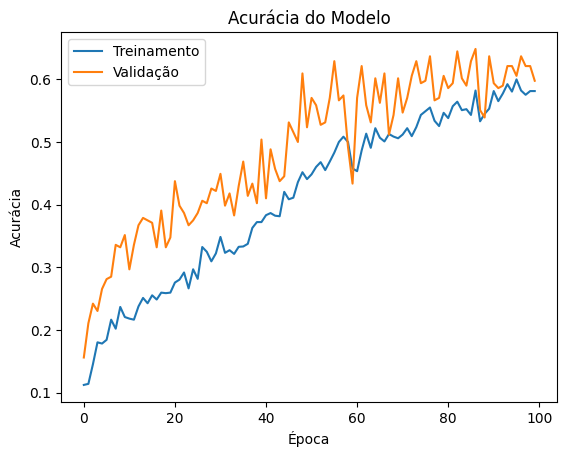

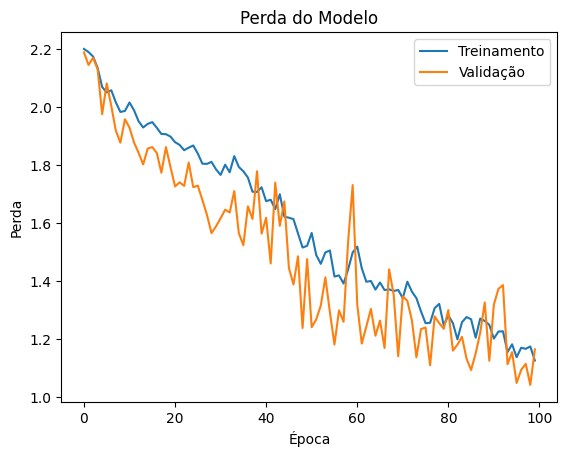

In [ ]:
# Plotar a acurácia e a perda durante o treinamento
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.show()

plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(['Treinamento', 'Validação'], loc='upper right')
plt.show()

In [ ]:
# Avaliar o modelo no conjunto de teste
test_loss, test_accuracy = cnn_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Acurácia no conjunto de teste:', test_accuracy)

1/1 [==============================] - 0s 241ms/step - loss: 1.0829 - accuracy: 0.6094
Acurácia no conjunto de teste: 0.609375


O modelo CNN Profunda mostrou um resultado mediano para o conjunto de teste com acuário de 60,93%. Esse foi o melhor resultado encontrado mesmo variando as configurações dos hiperparãemtros do modelo.

### Modelo Resnet50
Discorrer um pouco sobre as vantagens de usar cada modelo.

In [ ]:
# Carregue o modelo ResNet50 pré-treinado (sem incluir as camadas totalmente conectadas no topo)
Resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Congele as camadas do modelo base para que elas não sejam treinadas novamente
Resnet_model.trainable = False

In [ ]:
# Crie o modelo final, adicionando camadas personalizadas no topo do modelo base
Resnet_model = tf.keras.models.Sequential([
    Resnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# Compile o modelo
Resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Exibir o resumo do modelo
Resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                      

In [ ]:
# Criar o callback para visualização das imagens durante o treinamento
tensorboard_callback = TensorBoard(log_dir='./logs')

In [ ]:
# Treinar o modelo e armazenar o histórico
history_Resnet50 = Resnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[tensorboard_callback]
)

Epoch 1/100
10/10 [==============================] - 13s 997ms/step - loss: 2.2472 - accuracy: 0.1007 - val_loss: 2.1855 - val_accuracy: 0.1562
Epoch 2/100
10/10 [==============================] - 9s 829ms/step - loss: 2.2092 - accuracy: 0.1007 - val_loss: 2.1731 - val_accuracy: 0.1562
Epoch 3/100
10/10 [==============================] - 8s 817ms/step - loss: 2.2002 - accuracy: 0.1151 - val_loss: 2.1892 - val_accuracy: 0.0664
Epoch 4/100
10/10 [==============================] - 9s 863ms/step - loss: 2.1975 - accuracy: 0.1151 - val_loss: 2.1627 - val_accuracy: 0.2344
Epoch 5/100
10/10 [==============================] - 9s 858ms/step - loss: 2.1879 - accuracy: 0.1168 - val_loss: 2.1663 - val_accuracy: 0.0703
Epoch 6/100
10/10 [==============================] - 9s 881ms/step - loss: 2.1724 - accuracy: 0.1379 - val_loss: 2.1097 - val_accuracy: 0.1914
Epoch 7/100
10/10 [==============================] - 9s 905ms/step - loss: 2.1605 - accuracy: 0.1375 - val_loss: 2.0706 - val_accuracy: 0.242

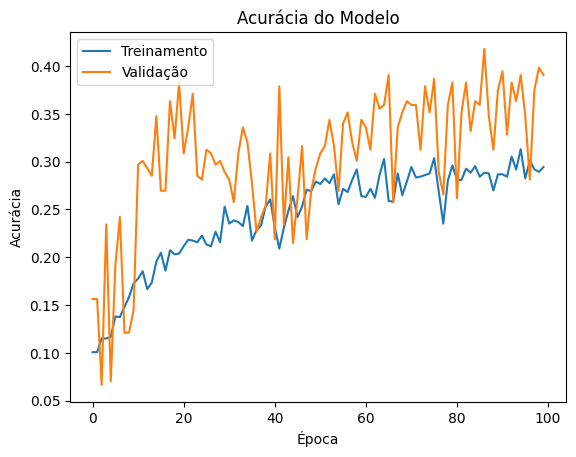

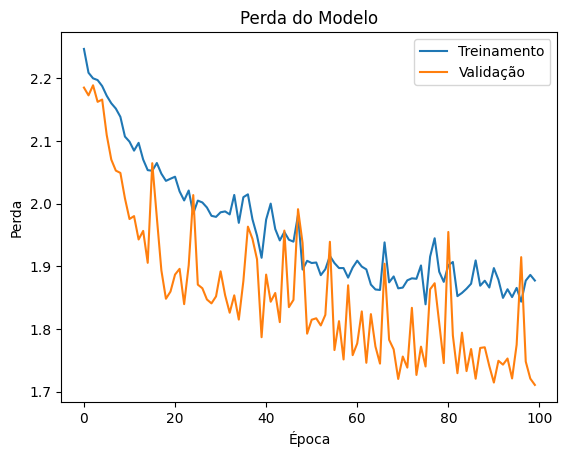

In [ ]:
# Plotar a acurácia e a perda durante o treinamento
plt.plot(history_Resnet50.history['accuracy'])
plt.plot(history_Resnet50.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.show()

plt.plot(history_Resnet50.history['loss'])
plt.plot(history_Resnet50.history['val_loss'])
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(['Treinamento', 'Validação'], loc='upper right')
plt.show()

In [ ]:
# Avaliar o modelo no conjunto de teste
test_loss, test_accuracy = Resnet_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Acurácia no conjunto de teste:', test_accuracy)

1/1 [==============================] - 0s 482ms/step - loss: 1.8033 - accuracy: 0.2812
Acurácia no conjunto de teste: 0.28125


Falar sobre esse resultado....

### Modelo InceptionV3
Discorrer um pouco sobre as vantagens de usar cada modelo.

##### Foi adicionada uma camada de 1024 neurônios, diminuuindo até chegar próximo ao número de saída, todas Dense, e uma camada de saida Danse de 9 neurônios representando cada uma das classes de estruturas. Foi estabelecido um fator de aprendizagem de 0.001, bem como a função de reativação 'relu' no final de cada camada intermediária.  Foi usado o Dropout também, que é uma técnica eficaz para combater o overfitting, fornecendo uma regularização interna durante o treinamento da rede neural. E para finalizar  as camadas, foi usado a função de reativação 'softmax', pois esse estudo se trata de uma classificação multiclasse.

In [ ]:
# Carregar o modelo InceptionV3 pré-treinado, usando os pesos da Imagenet e informado o tamanho das imagens.
Inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Congelar todas as camadas do modelo base
for layer in Inception_model.layers:
    layer.trainable = False

In [ ]:
# Crie o modelo final, adicionando camadas personalizadas no topo do modelo base
Inception_model = tf.keras.models.Sequential([
    Inception_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# Compilar o modelo
Inception_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Exibir o resumo do modelo
Inception_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                      

In [ ]:
# Criar o callback para visualização das imagens durante o treinamento
tensorboard_callback = TensorBoard(log_dir='./logs')

In [ ]:
es = EarlyStopping(patience=4)
rlr = ReduceLROnPlateau(monitor='val_loss', patience=4)
mc = ModelCheckpoint(filepath='best_{epoch:03d}-{val_loss:.4f}.h5', save_best_only=True)

#### Após a configuração da rede, é possível realizar o treinamento utilizando o conjunto de dados de amostras geológicas. Durante o treinamento, é importante monitorar as métricas de desempenho da rede, como acurácia e perda. Para isto, foram usados os callbacks EarlyStopping e ReduceLROnPlateau para interromper o treinamento no momento de ter ganhos não significativos junto com o ModelCheckpoint que permite salvar o modelo com melhor eficiência.

In [ ]:
# Treinar o modelo e armazenar o histórico
history_Inception = Inception_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[tensorboard_callback]
)

Epoch 1/100
10/10 [==============================] - 13s 1s/step - loss: 2.2406 - accuracy: 0.1303 - val_loss: 2.0726 - val_accuracy: 0.2539
Epoch 2/100
10/10 [==============================] - 9s 920ms/step - loss: 2.0497 - accuracy: 0.2276 - val_loss: 1.7787 - val_accuracy: 0.5586
Epoch 3/100
10/10 [==============================] - 9s 835ms/step - loss: 1.8193 - accuracy: 0.3393 - val_loss: 1.4032 - val_accuracy: 0.6758
Epoch 4/100
10/10 [==============================] - 8s 821ms/step - loss: 1.7195 - accuracy: 0.4010 - val_loss: 1.3263 - val_accuracy: 0.6406
Epoch 5/100
10/10 [==============================] - 8s 832ms/step - loss: 1.5067 - accuracy: 0.4924 - val_loss: 1.0608 - val_accuracy: 0.7148
Epoch 6/100
10/10 [==============================] - 8s 827ms/step - loss: 1.3265 - accuracy: 0.5296 - val_loss: 0.7893 - val_accuracy: 0.7930
Epoch 7/100
10/10 [==============================] - 8s 816ms/step - loss: 1.2484 - accuracy: 0.5846 - val_loss: 0.8671 - val_accuracy: 0.7578
E

In [ ]:
# Avaliar o modelo no conjunto de teste
test_loss, test_accuracy = Inception_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Acurácia no conjunto de teste:', test_accuracy)

1/1 [==============================] - 0s 354ms/step - loss: 0.4557 - accuracy: 0.8906
Acurácia no conjunto de teste: 0.890625


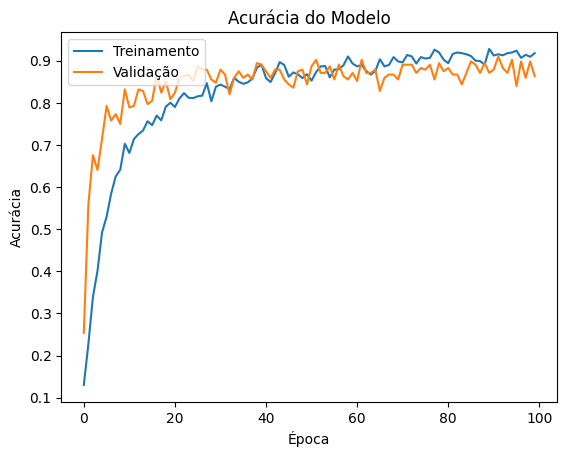

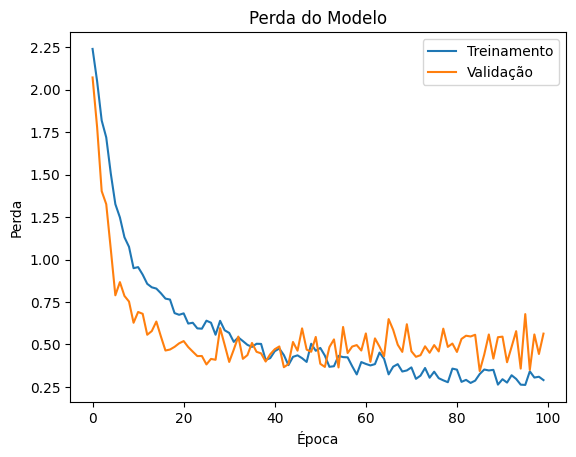

In [ ]:
# Plotar a acurácia e a perda durante o treinamento
plt.plot(history_Inception.history['accuracy'])
plt.plot(history_Inception.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.show()

plt.plot(history_Inception.history['loss'])
plt.plot(history_Inception.history['val_loss'])
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(['Treinamento', 'Validação'], loc='upper right')
plt.show()

In [ ]:
# Salvar o modelo InceptionV3
Inception_model.save('D:/Pessoal/Estudos_Pessoais/Pos_Graduacao/Clone_GitHub/Sprint_2/Deep_Learning/Geological_Structures/Models_Train/MVP_Sprint2.h5')

4/4 [==============================] - 1s 112ms/step


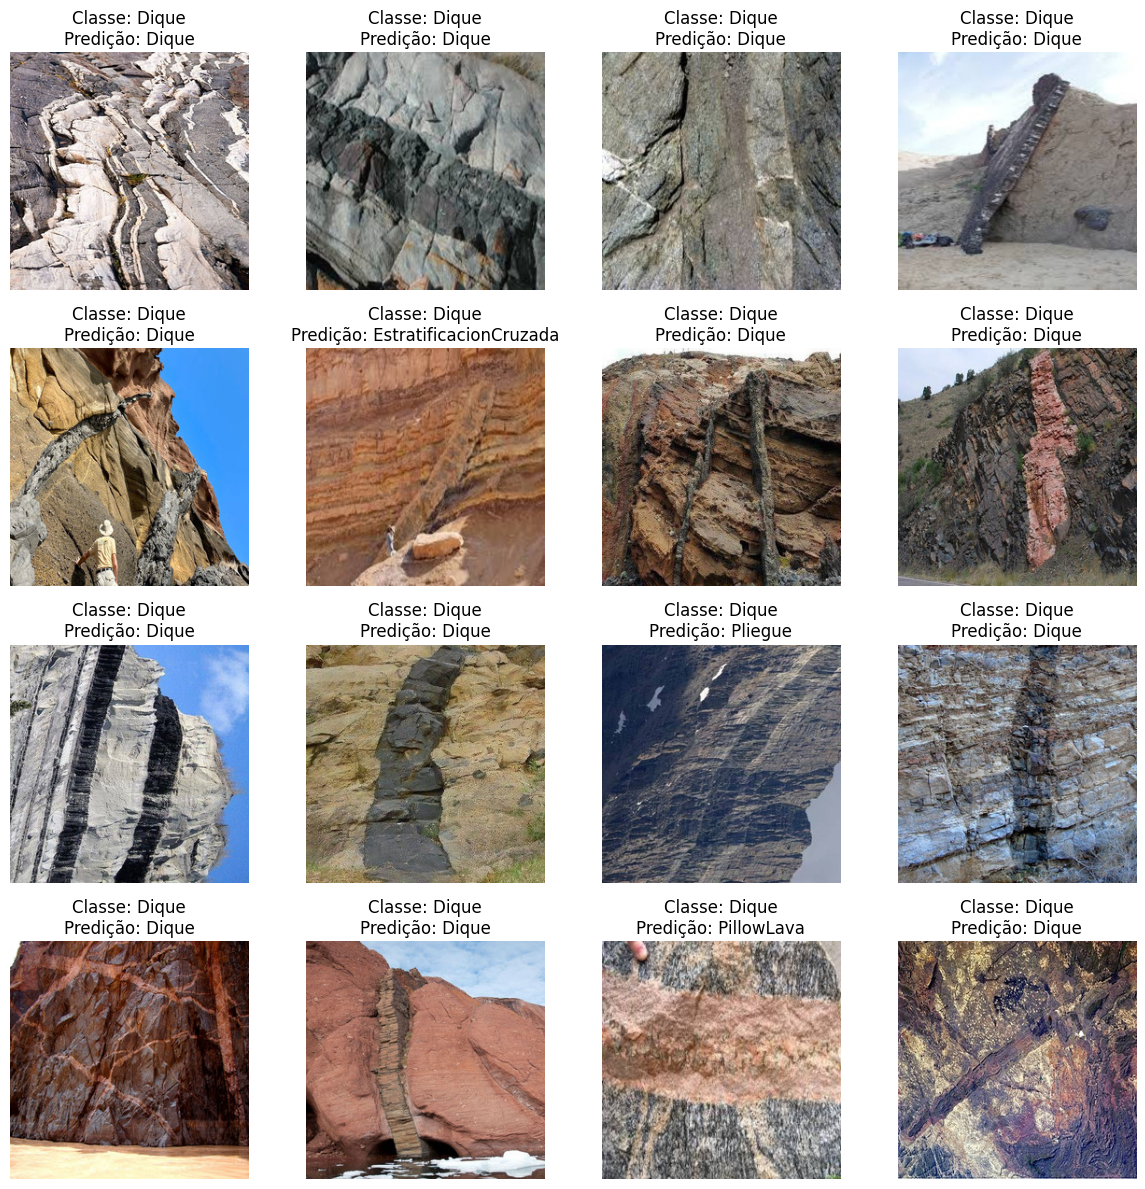

In [ ]:
# Visualizar algumas imagens do conjunto de validação e suas classes
class_names = sorted(validation_generator.class_indices.keys())
images, labels = next(validation_generator)
predicted_labels = Inception_model.predict(images)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img = images[i]
    label = np.argmax(labels[i])
    predicted_label = np.argmax(predicted_labels[i])

    ax.imshow(img)
    ax.set_title(f'Classe: {class_names[label]}\nPredição: {class_names[predicted_label]}')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Fazer previsões nas imagens de teste
predictions = Inception_model.predict(test_generator)

# Obter as classes preditas para cada imagem
predicted_classes = np.argmax(predictions, axis=1)

# Obter as classes reais para cada imagem
true_classes = test_generator.classes

# Obter os rótulos das classes
class_labels = list(test_generator.class_indices.keys())

2/2 [==============================] - 2s 530ms/step


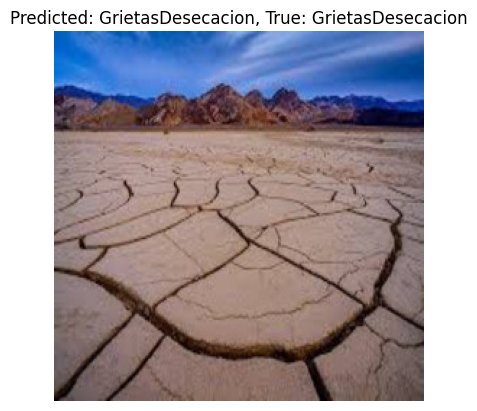

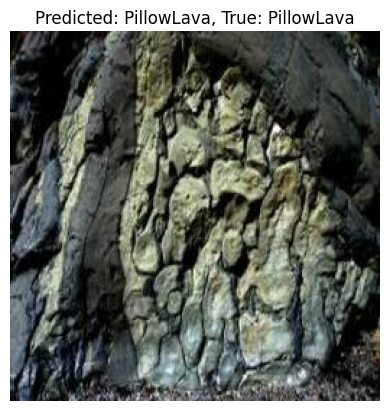

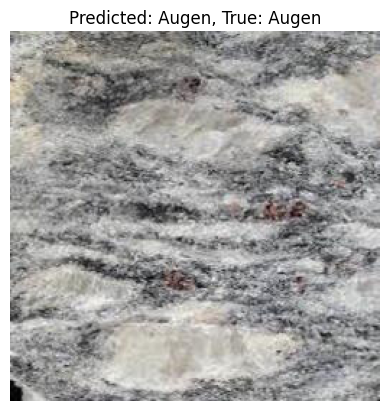

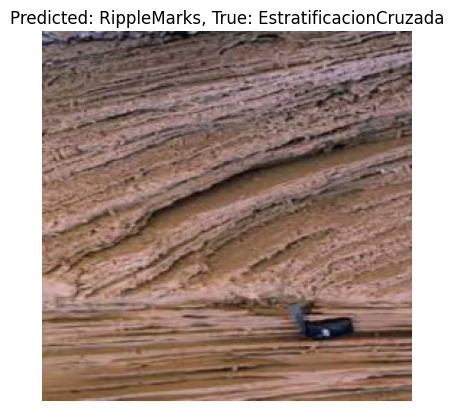

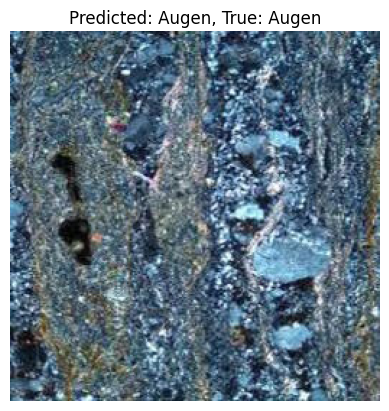

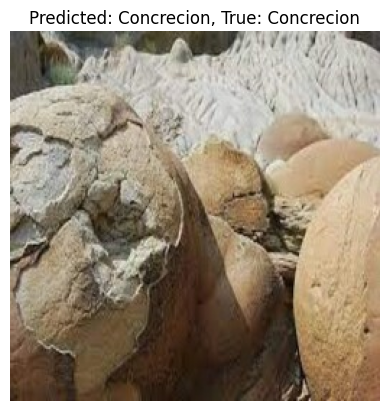

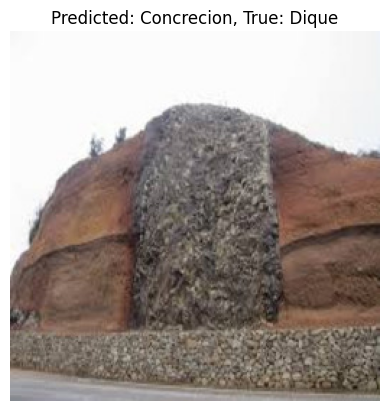

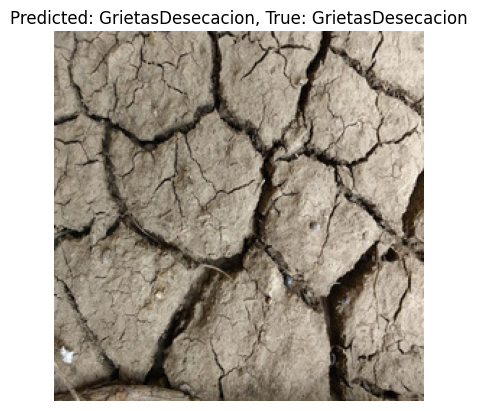

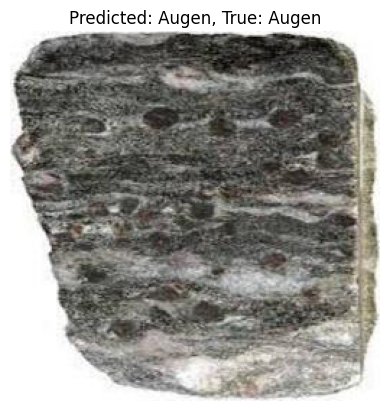

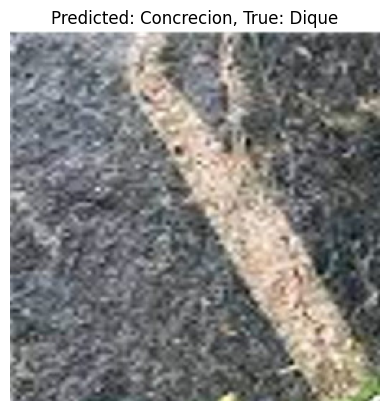

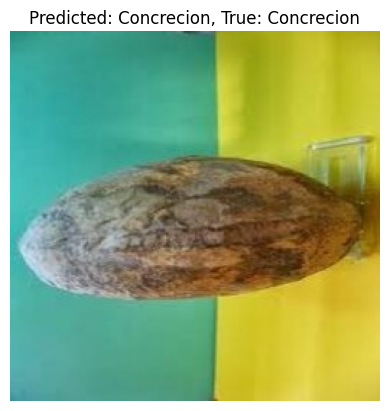

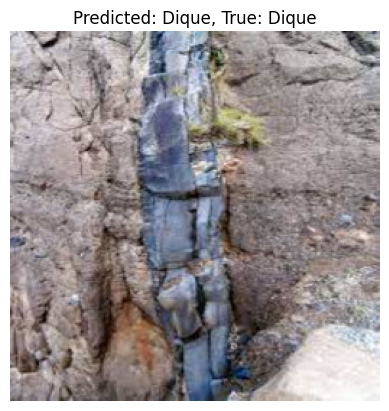

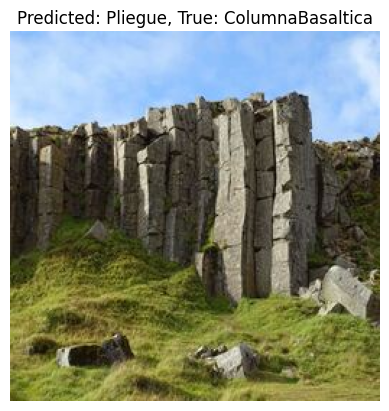

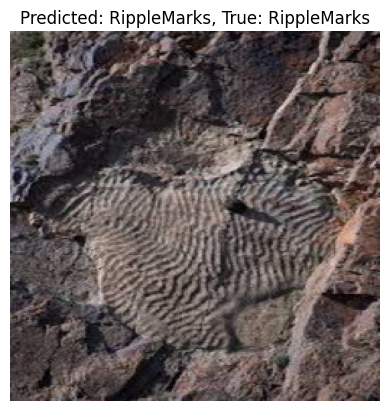

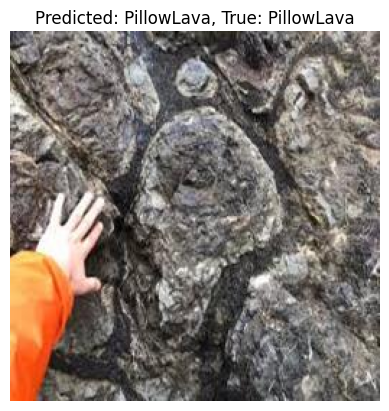

In [ ]:
# Mostrar algumas imagens de teste com suas classes preditas e reais
num_images = 15  # Número de imagens para mostrar
sample_indices = np.random.choice(len(test_generator.filenames), num_images, replace=False)
for idx in sample_indices:
    image_path = os.path.join(diretorio_teste, test_generator.filenames[idx])
    image = Image.open(image_path)
    predicted_class = class_labels[predicted_classes[idx]]
    true_class = class_labels[true_classes[idx]]
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}, True: {true_class}')
    plt.axis('off')
    plt.show()

### Rodando os modelos CNN Profunda e Inception com Cross Validation para tentar melhorar mais ainda o resultado.

In [ ]:
# Lista para armazenar as métricas de avaliação
accuracy_scores = []

In [ ]:
# Pré-processamento dos dados, vou mudar um pouco os valores do treinamento para diversificar mais os dados.
train_datagen = ImageDataGenerator(rescale=1./255,  # Normalização
    rotation_range=30,  # Rotação aleatória de até 30 graus
    width_shift_range=0.3,  # Deslocamento horizontal aleatório
    height_shift_range=0.3,  # Deslocamento vertical aleatório
    shear_range=0.3,  # Cisalhamento aleatório
    zoom_range=0.3,  # Zoom aleatório
    horizontal_flip=True,  # Espelhamento horizontal aleatório
    fill_mode='nearest')  # Modo de preenchimento)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Carregar os dados de treinamento
train_data = train_datagen.flow_from_directory(diretorio_treino,
                                              target_size=(256, 256),
                                              batch_size=batch_size,
                                              class_mode='categorical')

# Carregar os dados de validação
val_data = val_datagen.flow_from_directory(diretorio_validacao,
                                          target_size=(256, 256),
                                          batch_size=batch_size,
                                          class_mode='categorical')

# Carregar os dados de teste
test_data = test_datagen.flow_from_directory(diretorio_teste,
                                            target_size=(256, 256),
                                            batch_size=batch_size,
                                            class_mode='categorical')

Found 1310 images belonging to 9 classes.
Found 360 images belonging to 9 classes.
Found 135 images belonging to 9 classes.


### CNN Profunda com Cross Validation

In [ ]:
# Realizar a validação cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kf.split(os.listdir(diretorio_treino)):
    # Obter os dados de treinamento e validação para o fold atual
    train_data = train_data # Carregar os dados de treinamento usando os índices train_index
    val_data = val_data # Carregar os dados de validação usando os índices val_index

    # Compilar o modelo
    cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Treinar o modelo
    cnn_model.fit(train_data, epochs=epochs, batch_size=batch_size, validation_data=val_data)

    # Avaliar o modelo nos dados de validação
    val_loss, val_accuracy = cnn_model.evaluate(val_data)
    accuracy_scores.append(val_accuracy)

Epoch 1/100
11/11 [==============================] - 10s 839ms/step - loss: 1.3796 - accuracy: 0.4992 - val_loss: 1.5105 - val_accuracy: 0.5111
Epoch 2/100
11/11 [==============================] - 9s 830ms/step - loss: 1.2941 - accuracy: 0.5466 - val_loss: 1.3941 - val_accuracy: 0.5278
Epoch 3/100
11/11 [==============================] - 9s 833ms/step - loss: 1.2352 - accuracy: 0.5626 - val_loss: 1.3279 - val_accuracy: 0.5250
Epoch 4/100
11/11 [==============================] - 9s 882ms/step - loss: 1.1722 - accuracy: 0.5786 - val_loss: 1.3182 - val_accuracy: 0.5472
Epoch 5/100
11/11 [==============================] - 9s 799ms/step - loss: 1.1923 - accuracy: 0.5695 - val_loss: 1.3555 - val_accuracy: 0.5611
Epoch 6/100
11/11 [==============================] - 9s 805ms/step - loss: 1.1889 - accuracy: 0.5740 - val_loss: 1.4152 - val_accuracy: 0.5250
Epoch 7/100
11/11 [==============================] - 10s 932ms/step - loss: 1.1959 - accuracy: 0.5863 - val_loss: 1.3047 - val_accuracy: 0.56

In [ ]:
# Calcular a média e o desvio padrão das métricas de avaliação
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

# Imprimir os resultados
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Std Accuracy: {std_accuracy}")

Mean Accuracy: 0.8130555748939514
Std Accuracy: 0.10247742285574832


In [ ]:
# Avaliar o modelo nos dados de teste separados
test_data = test_data # Carregar os dados de teste
test_loss, test_accuracy = cnn_model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy}")

2/2 [==============================] - 0s 38ms/step - loss: 1.2350 - accuracy: 0.7704
Test Accuracy: 0.770370364189148


In [ ]:
# Salvar o modelo Inception com Cross Validation
cnn_model.save('D:/Pessoal/Estudos_Pessoais/Pos_Graduacao/Clone_GitHub/Sprint_2/Deep_Learning/Geological_Structures/Models_Train/MVP_Sprint2_Depp_CNN_Cross_Validation.h5')

### InceptionV3 com Cross Validation

In [ ]:
# Realizar a validação cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kf.split(os.listdir(diretorio_treino)):
    # Obter os dados de treinamento e validação para o fold atual
    train_data = train_data # Carregar os dados de treinamento usando os índices train_index
    val_data = val_data # Carregar os dados de validação usando os índices val_index

    # Compilar o modelo
    Inception_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Treinar o modelo
    Inception_model.fit(train_data, epochs=epochs, batch_size=batch_size, validation_data=val_data)

    # Avaliar o modelo nos dados de validação
    val_loss, val_accuracy = Inception_model.evaluate(val_data)
    accuracy_scores.append(val_accuracy)

Epoch 1/100
11/11 [==============================] - 14s 960ms/step - loss: 0.3833 - accuracy: 0.8908 - val_loss: 0.4354 - val_accuracy: 0.9028
Epoch 2/100
11/11 [==============================] - 9s 818ms/step - loss: 0.3362 - accuracy: 0.8985 - val_loss: 0.5210 - val_accuracy: 0.8806
Epoch 3/100
11/11 [==============================] - 9s 815ms/step - loss: 0.3597 - accuracy: 0.9038 - val_loss: 0.4676 - val_accuracy: 0.8833
Epoch 4/100
11/11 [==============================] - 9s 813ms/step - loss: 0.3098 - accuracy: 0.9092 - val_loss: 0.4342 - val_accuracy: 0.8944
Epoch 5/100
11/11 [==============================] - 9s 814ms/step - loss: 0.3363 - accuracy: 0.8947 - val_loss: 0.4416 - val_accuracy: 0.8778
Epoch 6/100
11/11 [==============================] - 9s 815ms/step - loss: 0.3541 - accuracy: 0.8954 - val_loss: 0.4861 - val_accuracy: 0.8806
Epoch 7/100
11/11 [==============================] - 9s 808ms/step - loss: 0.2704 - accuracy: 0.9260 - val_loss: 0.4526 - val_accuracy: 0.888

In [ ]:
# Calcular a média e o desvio padrão das métricas de avaliação
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

# Imprimir os resultados
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Std Accuracy: {std_accuracy}")

Mean Accuracy: 0.9127778053283692
Std Accuracy: 0.006478829941497031


In [ ]:
# Avaliar o modelo nos dados de teste separados
test_data = test_data # Carregar os dados de teste
test_loss, test_accuracy = Inception_model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy}")

2/2 [==============================] - 0s 23ms/step - loss: 0.3759 - accuracy: 0.9259
Test Accuracy: 0.9259259104728699


In [ ]:
# Salvar o modelo Inception com Cross Validation
Inception_model.save('D:/Pessoal/Estudos_Pessoais/Pos_Graduacao/Clone_GitHub/Sprint_2/Deep_Learning/Geological_Structures/Models_Train/MVP_Sprint2_Inception_Cross_Validation.h5')